In [13]:
# Gerekli Kütüphaneler
import pandas as pd # Veri analizi için pandas kütüphanesini içe aktarıyoruz. Excel veya CSV dosyalarını okumakta çok işe yarıyor.
import numpy as np  # Matematiksel işlemler ve dizilerle çalışmak için numpy kütüphanesini ekliyoruz.
from sklearn.ensemble import RandomForestRegressor  # Rastgele orman regresyon modeli için gerekli sınıf içe aktarılıyor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Model performansını ölçmek için metrikler ekleniyor
import matplotlib.pyplot as plt    # Grafik çizimleri için matplotlib kütüphanesi kullanılıyor
import seaborn as sns   # Daha estetik grafikler için seaborn kütüphanesi ekleniyor
from sklearn.model_selection import train_test_split  # Veriyi eğitim ve test seti olarak rastgele bölen fonksiyon
from sklearn.preprocessing import StandardScaler     # Özellikleri standartlaştırmak için kullanılan ölçekleyici

In [14]:
df = pd.read_csv(r"XAU_15m_data_2004_to_2024-20-09.csv")   # CSV dosyasından veriyi okuyoruz

print("\nVerinin boyutu (satır × sütun):")
print(df.shape)   # Kaç satır ve sütun olduğunu gösteriyor

print("\nVerinin ilk 5 satırı:")
display(df.head())  # İlk 5 satıra bakıyoruz

if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Tarih sütununu datetime tipine çevirme

df = df.sort_values(by="Date")   # Veriyi tarih sırasına göre sıralama

print("\nEksik değer sayısı:")
display(df.isnull().sum())   # Hangi sütunda kaç eksik var bakıyoruz


Verinin boyutu (satır × sütun):
(464737, 7)

Verinin ilk 5 satırı:


,Date,Time,Open,High,Low,Close,Volume
0,2004.06.11,07:15,384.0,384.3,383.8,384.3,12
1,2004.06.11,07:30,383.8,384.3,383.6,383.8,12
2,2004.06.11,07:45,383.3,383.8,383.3,383.8,20
3,2004.06.11,08:00,383.8,384.1,383.6,383.6,8
4,2004.06.11,08:15,383.6,384.3,383.5,383.5,20



Eksik değer sayısı:


Date      0
Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [15]:
print("\nTemizlik öncesi eksik değerler:")
print(df.isnull().sum())    # Çoğu altın verisinde eksik değer yok, ama yine de kontrol edelim:

numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']  # Sayısal sütunlar

for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mean(), inplace=True)   # Eksikleri ortalama ile dolduruyorum

if 'Date' in df.columns:  # Tarih sütununda eksik varsa = satırı sil
    df = df.dropna(subset=['Date'])  

print("\nEksik değerler işlendi.")   # Temizlik bitti

numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']   # Tekrar kontrol için liste

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)  # İlk çeyrek
    Q3 = df[col].quantile(0.75)  # Üçüncü çeyrek
    IQR = Q3 - Q1                # IQR hesaplama
    
    lower_bound = Q1 - 1.5 * IQR  # Alt sınır
    upper_bound = Q3 + 1.5 * IQR  # Üst sınır
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]   # Aykırı değerleri buluyor
    print(f" {col}: Aykırı değer sayısı = {len(outliers)}")            # Kaç tane olduklarını yazdırıyor


Temizlik öncesi eksik değerler:
Date      0
Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Eksik değerler işlendi.
 Open: Aykırı değer sayısı = 0
 High: Aykırı değer sayısı = 0
 Low: Aykırı değer sayısı = 0
 Close: Aykırı değer sayısı = 0
 Volume: Aykırı değer sayısı = 24330


In [16]:
# Feature engineering işlemleri yapılıyor

if 'Time' in df.columns:   # Eğer Time sütunu varsa Date ile birleştirilerek tam zaman oluşturuluyor
    df['Datetime'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Time'])
else:     # Yoksa sadece Date üzerinden Datetime oluşturuluyor
    df['Datetime'] = df['Date']

df = df.sort_values('Datetime').reset_index(drop=True)    # Veriyi zaman sırasına göre sıralama

df = df[df['Close'].diff() != 0].reset_index(drop=True)   # Önceki kapanış fiyatı ile aynıysa tekrar eden satırları kaldırma

# Zaman özellikleri ekleme
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day
df['Hour'] = df['Datetime'].dt.hour
df['Weekday'] = df['Datetime'].dt.weekday  # 0 = Pazartesi, 6 = Pazar

# Temel fiyat farkı özellikleri hesaplanıyor
df['High_Low_Diff'] = df['High'] - df['Low']
df['Close_Open_Diff'] = df['Close'] - df['Open']
df['High_Close_Diff'] = df['High'] - df['Close']
df['Low_Close_Diff'] = df['Low'] - df['Close']

# Hareketli ortalama ve standart sapma özellikleri oluşturuluyor
for w in [3,5,10]:
    df[f'MA_Close_{w}'] = df['Close'].rolling(window=w).mean()
    df[f'STD_Close_{w}'] = df['Close'].rolling(window=w).std()
    df[f'MA_High_{w}'] = df['High'].rolling(window=w).mean()
    df[f'MA_Low_{w}'] = df['Low'].rolling(window=w).mean()

# Fiyatın önceki kapanış ile farkı (lag features)
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
df['Close_Lag3'] = df['Close'].shift(3)

# Momentum hesaplamaları yapılıyor
df['Momentum_1'] = df['Close'] - df['Close_Lag1']
df['Momentum_2'] = df['Close'] - df['Close_Lag2']

# İlk 10 satırı göster
print("\nGeliştirilmiş Feature Engineering sonrası veri:")
display(df.head(10))


Geliştirilmiş Feature Engineering sonrası veri:


,Date,Time,Open,High,Low,Close,Volume,Datetime,Year,Month,...,MA_Low_5,MA_Close_10,STD_Close_10,MA_High_10,MA_Low_10,Close_Lag1,Close_Lag2,Close_Lag3,Momentum_1,Momentum_2
0,2004-06-11,07:15,384.0,384.3,383.8,384.3,12,2004-06-11 07:15:00,2004,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-06-11,07:30,383.8,384.3,383.6,383.8,12,2004-06-11 07:30:00,2004,6,...,NaN,NaN,NaN,NaN,NaN,384.3,NaN,NaN,-0.5,NaN
2,2004-06-11,08:00,383.8,384.1,383.6,383.6,8,2004-06-11 08:00:00,2004,6,...,NaN,NaN,NaN,NaN,NaN,383.8,384.3,NaN,-0.2,-0.7
3,2004-06-11,08:15,383.6,384.3,383.5,383.5,20,2004-06-11 08:15:00,2004,6,...,NaN,NaN,NaN,NaN,NaN,383.6,383.8,384.3,-0.1,-0.3
4,2004-06-11,08:45,383.3,383.3,383.1,383.1,6,2004-06-11 08:45:00,2004,6,...,383.52,NaN,NaN,NaN,NaN,383.5,383.6,383.8,-0.4,-0.5
5,2004-06-11,09:00,383.1,384.1,383.1,383.6,9,2004-06-11 09:00:00,2004,6,...,383.38,NaN,NaN,NaN,NaN,383.1,383.5,383.6,0.5,0.1
6,2004-06-11,09:15,383.8,384.0,382.8,383.0,15,2004-06-11 09:15:00,2004,6,...,383.22,NaN,NaN,NaN,NaN,383.6,383.1,383.5,-0.6,-0.1
7,2004-06-11,09:45,383.0,383.3,382.8,383.1,11,2004-06-11 09:45:00,2004,6,...,383.06,NaN,NaN,NaN,NaN,383.0,383.6,383.1,0.1,-0.5
8,2004-06-11,10:00,383.0,383.6,383.0,383.6,10,2004-06-11 10:00:00,2004,6,...,382.96,NaN,NaN,NaN,NaN,383.1,383.0,383.6,0.5,0.6
9,2004-06-11,12:45,383.8,383.8,383.3,383.3,4,2004-06-11 12:45:00,2004,6,...,383.00,383.49,0.390014,383.91,383.26,383.6,383.1,383.0,-0.3,0.2


In [17]:
# veriyi %80 eğitim / %20 test olarak bölüm
df.dropna(inplace=True)   # Veri içindeki eksik kayıtlar temizleniyor

y = df['Close']     # Tahmin edilecek hedef değer olarak 'Close' sütunu seçiliyor

# Modelde kullanılacak özellik sütunları belirleniyor
X = df.drop(['Close', 'Date', 'Datetime', 'Time'], axis=1, errors='ignore')   

# Veri %80 eğitim, %20 test olarak ayrılıyor
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# Özelliklerin ölçeklendirilmesi için standartlaştırıcı tanımlanıyor
scaler = StandardScaler()

# Eğitim verisi ölçeklendiriliyor
X_train_scaled = scaler.fit_transform(X_train)
# Test verisi aynı scaler ile dönüştürülüyor
X_test_scaled = scaler.transform(X_test)

# Son durumu gösterme
print("\nVeriler modeller için hazır:")
print(f"X_train: {X_train_scaled.shape}, X_test: {X_test_scaled.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


Veriler modeller için hazır:
X_train: (357277, 30), X_test: (89320, 30)
y_train: (357277,), y_test: (89320,)


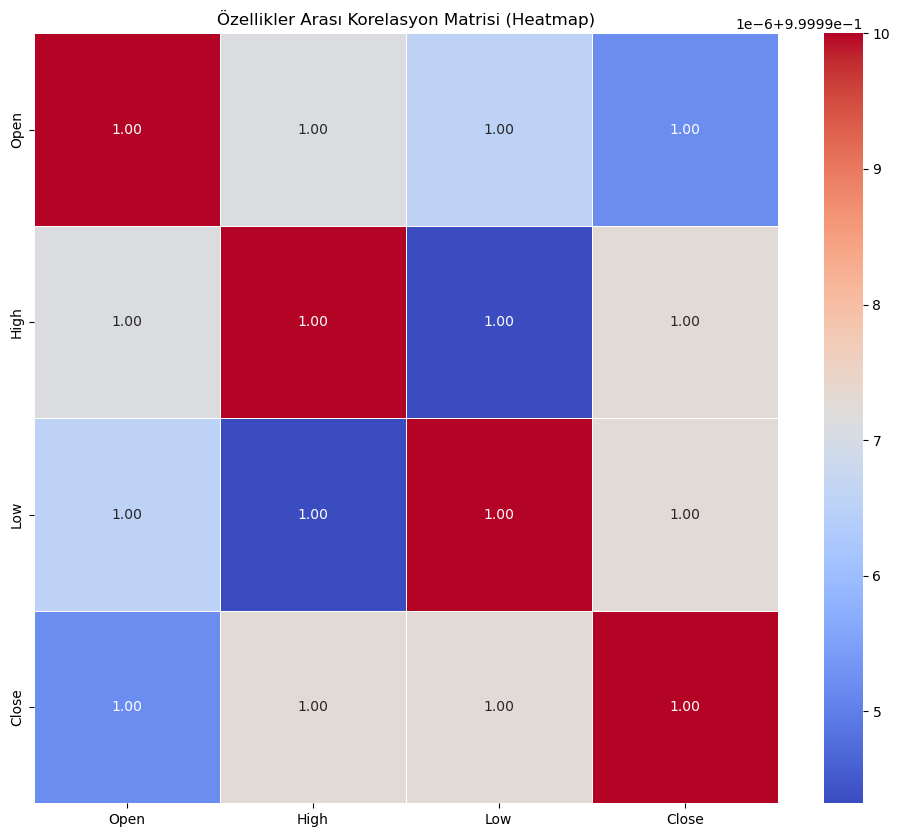

In [18]:
df = pd.read_csv(r"XAU_15m_data_2004_to_2024-20-09.csv") 
# Sadece sayısal sütunları alalım
numerical_df = df.select_dtypes(include=[np.number])

# Korelasyon hesapla
corr_matrix = numerical_df.corr()

# Hedef değişken (Close) ile en yüksek korelasyona sahip 10 özelliği bul
top_corr_features = corr_matrix.index[abs(corr_matrix["Close"]) > 0.5]

plt.figure(figsize=(12, 10))
plt.title("Özellikler Arası Korelasyon Matrisi (Heatmap)")
# Sadece en ilişkili özellikleri çizelim ki grafik karışmasın
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show()

In [19]:
# BASELINE MODELİN KURULMASI (RANDOM FOREST)

print("\n🌲Random Forest (Baseline) Modeli Eğitiliyor...")   
print("(Veri seti büyük olduğu için bu işlem işlemcinize bağlı olarak biraz zaman alabilir...)")

# Modeli Tanımlama
# n_estimators=100: 100 adet karar ağacı kullanılır. n_jobs=-1: Bilgisayarın tüm işlemci çekirdeklerini kullanarak hızlandırır.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf_model.fit(X_train_scaled, y_train)    # Model ölçeklenmiş eğitim verisi üzerinde eğitiliyor

rf_pred = rf_model.predict(X_test_scaled)   # Eğitilen model ile test verisi üzerinden tahminler üretiliyor

print("Model eğitimi tamamlandı.")   # Eğitim sürecinin başarılı şekilde bittiği bildiriliyor


🌲Random Forest (Baseline) Modeli Eğitiliyor...
(Veri seti büyük olduğu için bu işlem işlemcinize bağlı olarak biraz zaman alabilir...)
Model eğitimi tamamlandı.


In [20]:
# BAŞARI METRİKLERİNİN HESAPLANMASI

# RMSE(Kök Ortalama Kare Hata) - Tahmin edilen değerler ile gerçek değerler arasındaki RMSE hesaplanıyor
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

# Ortalama Mutlak Hata (MAE) hesaplanıyor
rf_mae = mean_absolute_error(y_test, rf_pred)
 
# R2 skoru ile modelin başarısı ölçülüyor (Modelin veriyi açıklama oranı - 1'e ne kadar yakınsa o kadar iyi)
rf_r2 = r2_score(y_test, rf_pred)

# Sonuçlar ekrana yazdırılıyor
print("\n-- BASELINE MODEL SONUÇLARI --")
print(f"RMSE (Hata Payı): {rf_rmse:.4f}")
print(f"MAE (Ortalama Hata): {rf_mae:.4f}")
print(f"R2 Skoru (Başarı): {rf_r2:.4f}")


-- BASELINE MODEL SONUÇLARI --
RMSE (Hata Payı): 119.4603
MAE (Ortalama Hata): 43.0510
R2 Skoru (Başarı): 0.6614


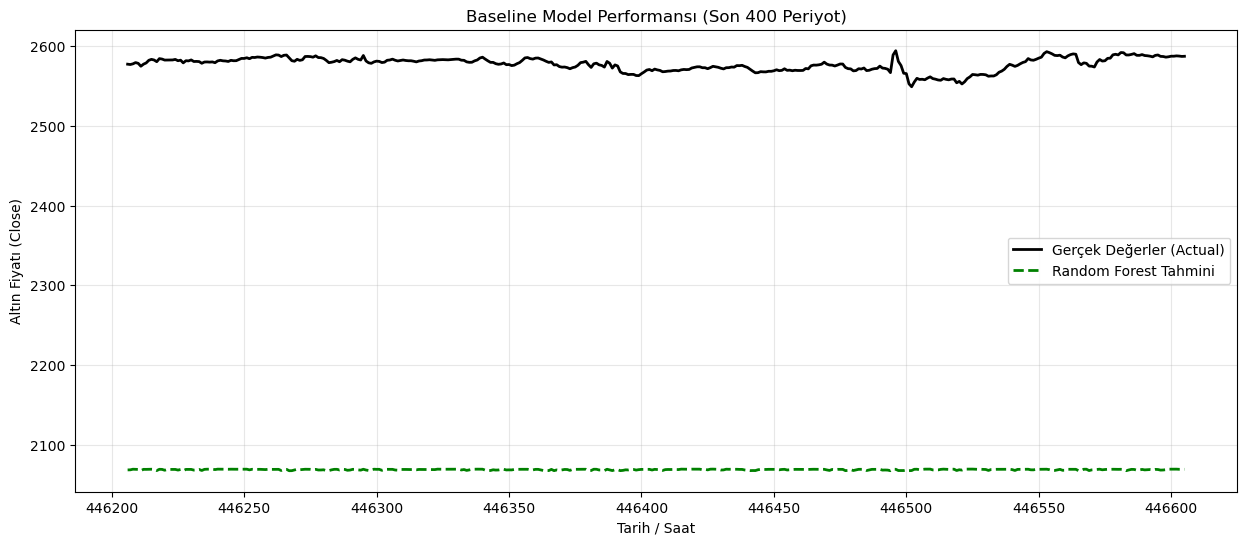

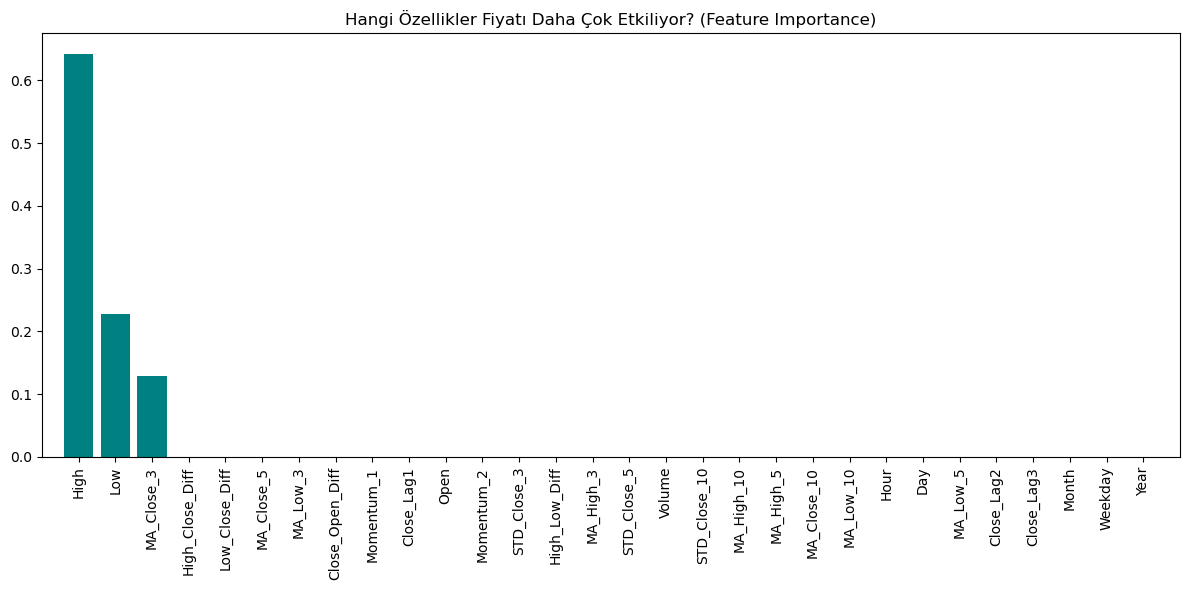

In [21]:
# SONUÇLARIN GÖRSELLEŞTİRİLMESİ (GRAFİKLER)

# 1.Grafik
last_n = 400   # Son 400 veriyi görselleştirmek için seçim
# Tüm veriyi çizersek grafik çok karışık olur, bu yüzden son kısmı yakınlaştırıyoruz.

# Gerçek ve tahmin edilen değerlerin çizimi
plt.figure(figsize=(15, 6))
plt.plot(y_test.index[-last_n:], y_test.iloc[-last_n:], label='Gerçek Değerler (Actual)', color='black', linewidth=2)
plt.plot(y_test.index[-last_n:], rf_pred[-last_n:], label='Random Forest Tahmini', color='green', linestyle='--', linewidth=2)
plt.title(f'Baseline Model Performansı (Son {last_n} Periyot)')
plt.xlabel('Tarih / Saat')
plt.ylabel('Altın Fiyatı (Close)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2.Grafik  Özellik önemlerinin (feature importance) hesaplanması ve görselleştirilmesi
# Hangi sütunun fiyat üzerinde en çok etkisi olduğunu gösterir.
feature_names = X.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1] # Büyükten küçüğe sırala

plt.figure(figsize=(12, 6))
plt.title("Hangi Özellikler Fiyatı Daha Çok Etkiliyor? (Feature Importance)")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='teal')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout() # Yazıların kesilmesini önler
plt.show()